In [68]:
import os
import sys
import importlib
from contextlib import redirect_stdout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set_style("ticks")
# Set default figure size globally
plt.rcParams['figure.figsize'] = [12, 6]
# sys.path.append(os.path.abspath('../Libraries'))
import volpe_library_2 as vl2 # type: ignore
# Forcing the reload of vl2 without the need of a jp kernel restart
with redirect_stdout(open(os.devnull, 'w')):
    importlib.reload(vl2)

In [39]:
# General parameters
verbose = True
n_params_fit_func = 4           # Nr of parameters of the fitting function for the peak (e.g. EMG)
bin_size = 10e-9                # Size of the bin, in seconds
t0_offset = 1e-5                # Temporal offset
plot_offset = 1e-3

In [40]:
# Dataframe creation
runlist = [427000+x for x in [300, 302, 304, 316]] # 300, 302, 304, 306, 307, 308, 309, 316
# base_df , _ = vl2.tof_load_df(runlist, 'C:\\Users\\marco\\experimental_raw_data\\HCI\\Databases', load_helper=False)
base_df = vl2.tof_df_creation(runlist, 'C:\\ALPACA\\analysis\\volpe\\Databases')

Loading the dataframe from the parquet file...
Dataframe correctly loaded!


                values    errors
5.000000e-09  0.001034  0.000295
1.500000e-08  0.000514  0.000331
2.500000e-08  0.000574  0.000485
3.500000e-08  0.000814  0.000241
4.500000e-08  0.000844  0.000413
...                ...       ...
8.995500e-05  0.000884  0.000167
8.996500e-05  0.000694  0.000199
8.997500e-05  0.000764  0.000096
8.998500e-05  0.000764  0.000354
8.999500e-05  0.000707  0.000258

[9000 rows x 2 columns]
mean error:	0.00031861055990375697
std of errors:	0.00012678612261054844


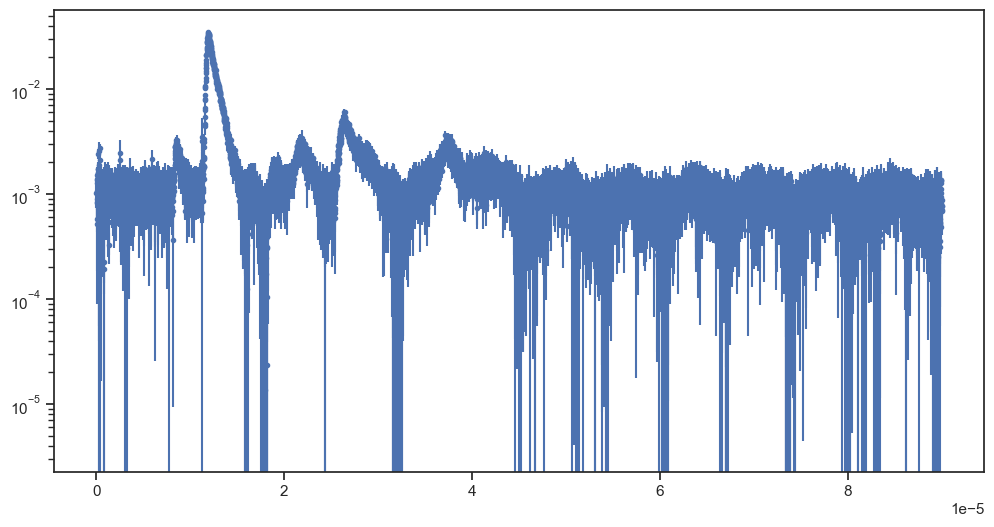

In [41]:
# Dataframe manipulation
df = vl2.massage_df(base_df, bin_size, t0_offset)
# Add a little known offset to plot in log scale
df['values'] += plot_offset

if verbose:
    print(df)
    # print(df[abs((df['errors'] - df['abs_err']))>0])
    # print(f'mean value:\t{df["values"].mean()}')
    print(f'mean error:\t{df["errors"].mean()}')
    print(f'std of errors:\t{df["errors"].std()}')
    # Let's try to plot the various graphs
    # sns.relplot(data=df[(base_df.index.values > 2e-5) & (base_df.index.values < 3e-5)], kind="line")
    # sns.relplot(data=df, kind="scatter")
    # plt.figure(figsize=(12, 6))
    plt.errorbar(df.index, df['values'], yerr=df['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # plt.xscale('log')
    # plt.yscale('symlog', linthresh=1e-4)

Ampl:	0.00019301131269838215
freq:	140432.68943497082
phi:	1.7562826828109368
offset:	0.0009911072222907268
exp_tau:	122.56886675431406
Condition number of the covariance matrix: 8.332070e+25
Diagonal values of pcov:
Cov of Ampl:	1.102202282722695e-09
Cov of freq:	169612.10152686873
Cov of phi:	0.03371633255817311
Cov of offset:	1.6299488191034215e-11
Cov of exp_tau:	1343302903119469.8
Chi-2: 4609.952125463422
dof:	3995
Reduced Chi^2:	1.1539304444213823
Goodness-of-Fit:	2.6420643450819625e-11
R-squared: 0.22214571198834465


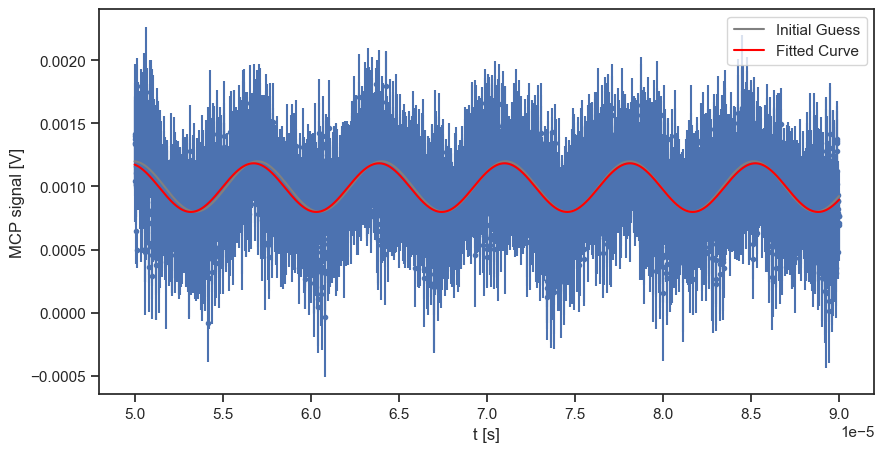

In [42]:
# Let's fit and remove the final oscillation
df_osc = df[(df.index > 5e-5)] # & (df.index <0.0001)]
# Function to fir the oscillation
def oscillation(x, Ampl, freq, phi, offset, exp_tau):
    return Ampl*np.sin(2*np.pi*freq*x+phi)*np.exp(-x/exp_tau) + offset #+exp_ampl*np.exp(-x/exp_tau) 
# Initial parameters array
par_i = [2e-04, 1.42e+05, 1, plot_offset, 1e-1]
# Perform the fit
osc_popt, osc_pcov = vl2.fit_n_plot_errors(df_osc, oscillation, par_i, ['Ampl', 'freq', 'phi', 'offset', 'exp_tau'], verbose=verbose)

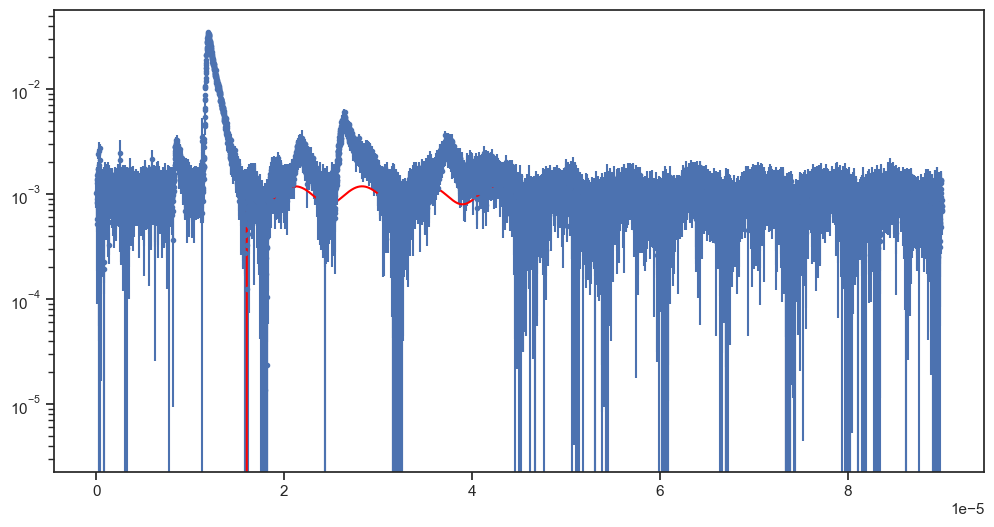

In [43]:
#Let's plot it on the full graph
start_oscillation = 1.6e-5
def cut_oscillation(x, osc_params):
    return np.heaviside(x-start_oscillation, 0)*oscillation(x, *osc_params)
if verbose:
    plt.errorbar(df.index, df['values'], yerr=df['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # x_fit = np.linspace(min(df.index.values), max(df.index.values), 1000)
    # x_fit = np.linspace(0.000026, max(df.index.values), 1000)
    plt.plot(df.index.values, cut_oscillation(df.index.values, osc_popt), label='fitted oscillation', color='red')

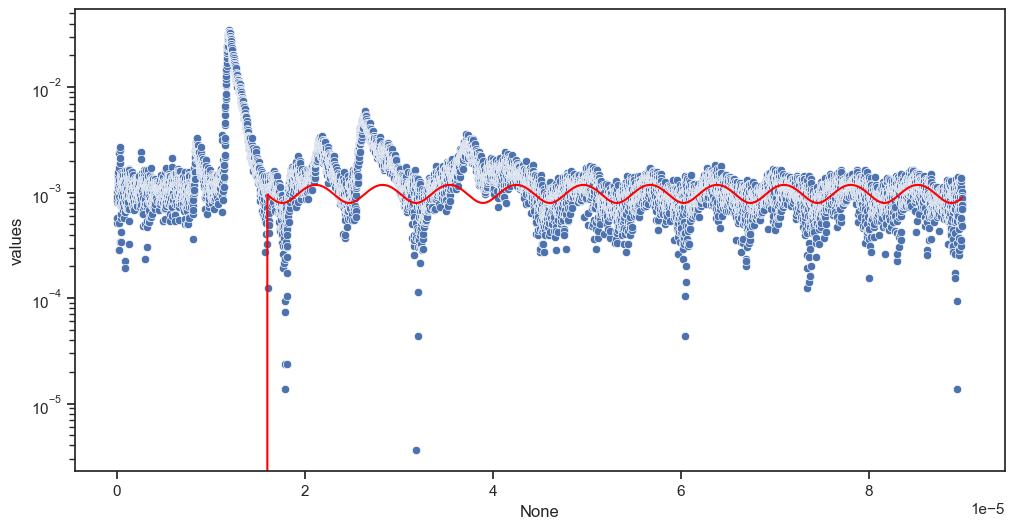

In [44]:
# Plot it with no errors to be more clear
if verbose:    
    # plt.scatter(df.index, df['values'], markersize=3)
    sns.scatterplot(data=df, x=df.index, y='values', sizes=(3,3))
    plt.yscale('log')
    # x_fit = np.linspace(min(df.index.values), max(df.index.values), 1000)
    # x_fit = np.linspace(0.000026, max(df.index.values), 1000)
    plt.plot(df.index.values, cut_oscillation(df.index.values, osc_popt), label='fitted oscillation', color='red')

I determined the x starting point for the oscillation by when the first peaks cross again the 0 (which is 10-3 in the above graph).

Height of the biggest peak: 0.03467360442827739


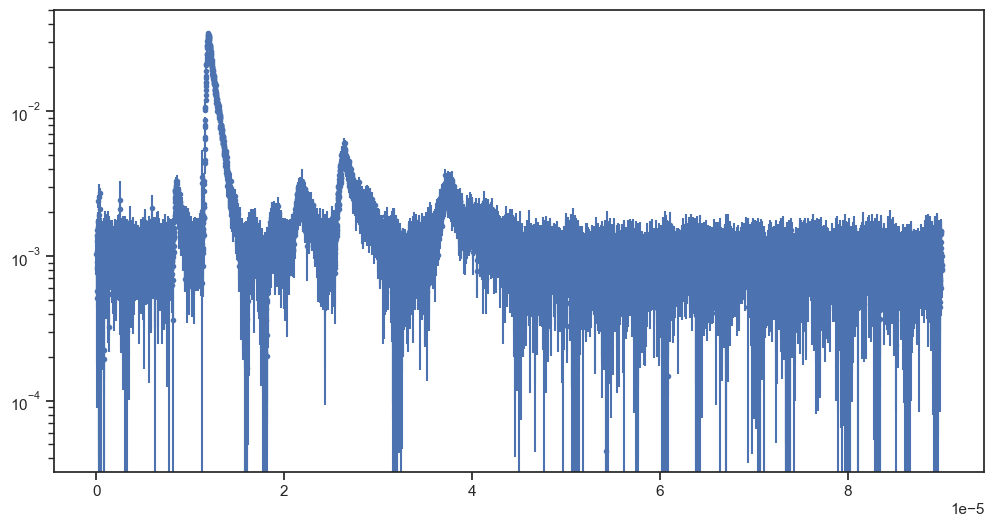

In [45]:
# Unbelievable! Let's remove it and re-plot the function
df2 = df.copy()
df2['values'] -= cut_oscillation(df2.index.values, osc_popt) - np.heaviside(df2.index.values-start_oscillation,0)*plot_offset
if verbose:
    plt.errorbar(df2.index, df2['values'], yerr=df2['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # Customize the ticks on the y-axis
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks at powers of 10
    plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks at intervals between powers of 10
    # plt.gca().yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels
    print(f'Height of the biggest peak: {max(df2["values"])}')

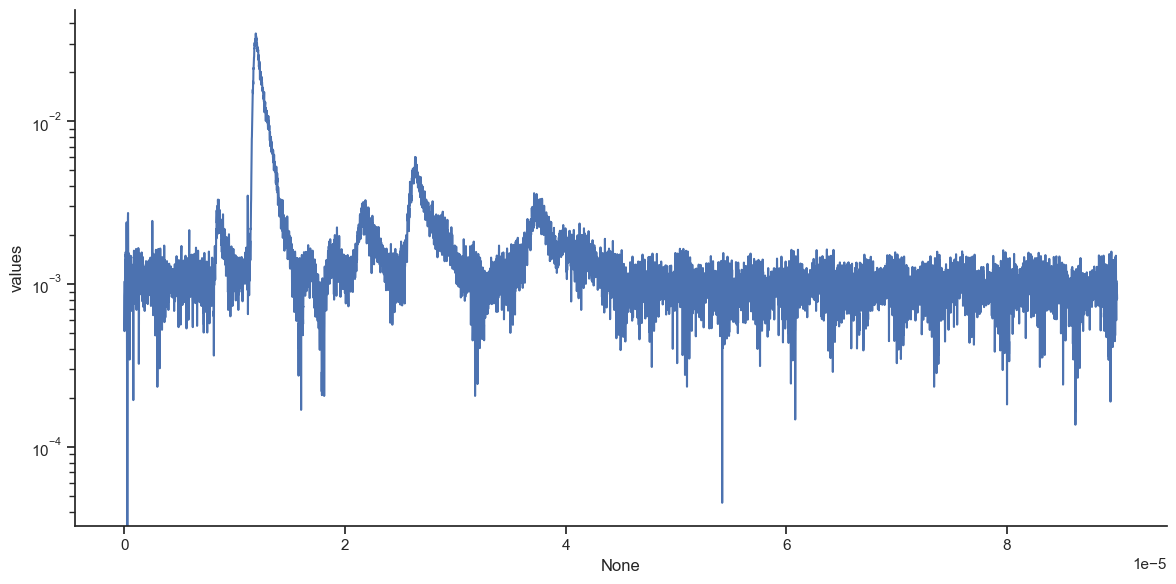

In [46]:
if verbose:
    sns.relplot(data=df2,x=df2.index,y='values', kind='line', height=6, aspect=2)
    plt.yscale('log')
    plt.show()

The maximum of the bigger peak is ~ 2e-2, and generates an oscillation of 4e-4, which is 2 OoM smaller.
Hence, the second biggest peak (around t = 0.000035), which is ~ 3e-3, should generate and oscillation of ~ 6e-5.
Maybe I can neglect it for the time being (but in the future I coud try to generate a similar waveform and subtract it).

Ampl:	3.4025497279930954e-08
mu:	1.1686735107800904e-05
sigma:	1.282816845714067e-07
lam:	1214589.2177399562
Condition number of the covariance matrix: 4.296685e+27
Diagonal values of pcov:
Cov of Ampl:	1.6006324478365232e-20
Cov of mu:	3.769202591883235e-18
Cov of sigma:	5.3868172609886585e-18
Cov of lam:	58109335.73945549
Chi-2: 1672.5112860687898
dof:	596
Reduced Chi^2:	2.8062269900483052
Goodness-of-Fit:	0.0
R-squared: 0.9934980782104866


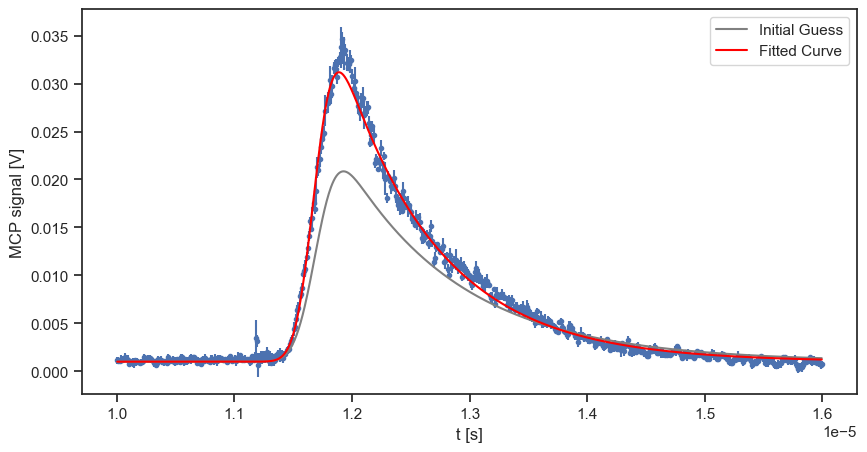

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [71]:
# OK, let's try to fit the peaks: start from biggest, with EMG2
# peaks, peaks_props = find_peaks(df2['values'], height=1e-3)
# peaks = find_peaks_cwt(df2['values'], [1e-6, 2e-6, 5e-6])
def peak_fit_func(x, ampl, mu, sigma, lam):
    return vl2.EMG2(x, ampl, mu, sigma, lam) + plot_offset

df_test = df2[(df2.index > 1e-5) & (df2.index < 1.6e-5)]
par_test_i = [2.65e-8, 1.17e-5, 1.4e-7, 1e6]
test_popt, test_pcov = vl2.fit_n_plot_errors(df_test, peak_fit_func, par_test_i, ['Ampl', 'mu', 'sigma', 'lam'], verbose=verbose)
fig = vl2._figures[-1]
ax = vl2._axes[-1]
ax.grid()
fig.savefig("example-fit-peak1.eps",dpi=600)

In [50]:
# Let's try with exponnorm
if False:
    # Roughly it corresponds to:
    # loc = mu
    # scale = sigma
    # K = 1/(sigma * lam)
    def peak_fit_func2(x, ampl, loc, scale, K):
        return vl2.EMG_exponnorm(x, ampl, loc, scale, K) + plot_offset

    df_test = df2[(df2.index > 1e-5) & (df2.index < 1.6e-5)]
    par_test_i = [2.65e-8, 1.17e-5, 1.4e-7, 7]
    test_popt, test_pcov = vl2.fit_n_plot_errors(df_test, peak_fit_func2, par_test_i, ['ampl', 'loc', 'scale', 'K'])

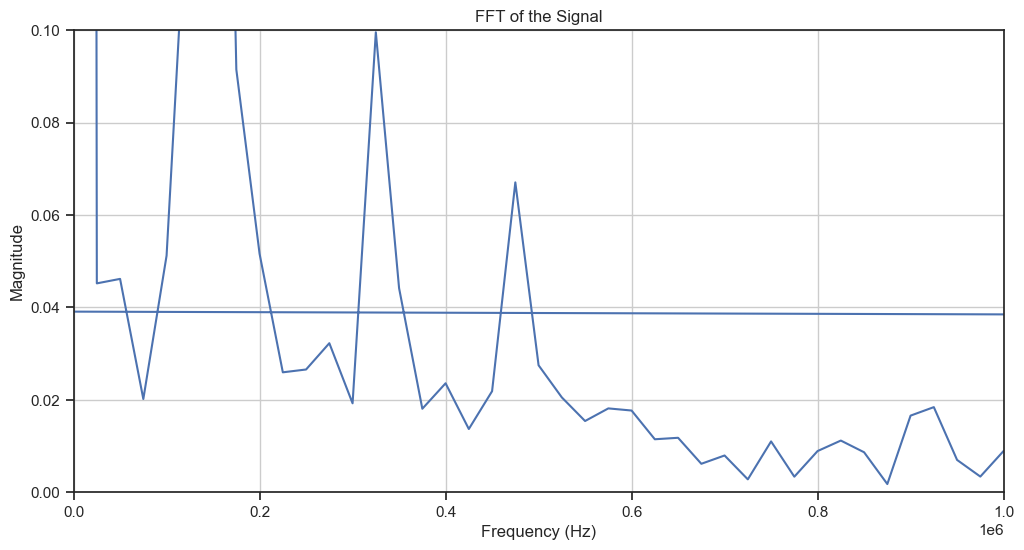

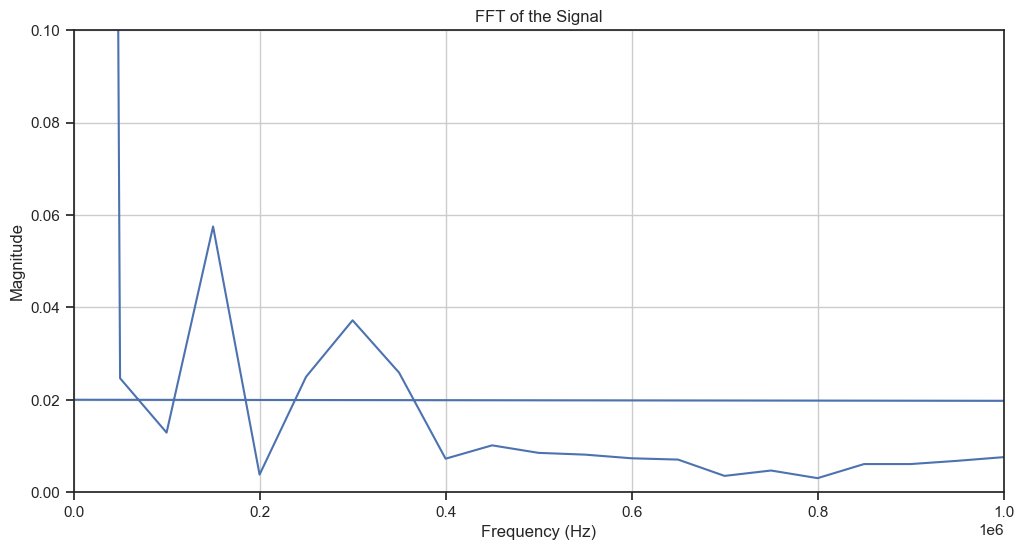

In [51]:
# Extract the further oscillation performing a FFT
if True:
    # Only on the tail of the function (i.e. df_osc)
    # Step 1: Extract the time points and values
    df_osc2 = df_osc #df2[(df2.index > 8e-5) & (df2.index < 10e-5)]
    # time = df_osc2.index.values  # Time points from the index
    values = df_osc2['values'].values  # Signal values
    # Step 2: Calculate the time spacing (delta_t)
    delta_t = bin_size #np.mean(np.diff(time))  # Time difference between consecutive points (assuming uniform sampling)
    # Step 3: Perform the FFT on the 'values' column
    fft_values = np.fft.fft(values)
    # Step 4: Compute the frequency axis
    frequencies = np.fft.fftfreq(len(values), delta_t)
    # Step 5 (Optional): Compute the magnitude of the FFT (since the result is complex)
    magnitude = np.abs(fft_values)
    # Plot the FFT result (frequency spectrum)
    plt.plot(frequencies, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT of the Signal')
    plt.xlim(0e5, 10e5)
    plt.ylim(0,0.1)
    plt.grid(True)
    plt.show()

    # Step 1: Extract the time points and values
    df_osc2 = df2[(df2.index > 7e-5)]# & (df2.index < 9e-5)]
    # time = df_osc2.index.values  # Time points from the index
    values = df_osc2['values'].values  # Signal values
    # Step 2: Calculate the time spacing (delta_t)
    delta_t = bin_size #np.mean(np.diff(time))  # Time difference between consecutive points (assuming uniform sampling)
    # Step 3: Perform the FFT on the 'values' column
    fft_values = np.fft.fft(values)
    # Step 4: Compute the frequency axis
    frequencies = np.fft.fftfreq(len(values), delta_t)
    # Step 5 (Optional): Compute the magnitude of the FFT (since the result is complex)
    magnitude = np.abs(fft_values)
    # Plot the FFT result (frequency spectrum)
    plt.plot(frequencies, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT of the Signal')
    plt.xlim(0e5, 1e6)
    plt.ylim(0,0.1)
    plt.grid(True)
    plt.show()

In [52]:
# Let's look for a second oscillation 
if False:
    # df_zoom = df2[(df2.index > 8e-5) & (df2.index < 10e-5)]
    # plt.figure(figsize=(12, 6))
    # plt.errorbar(df_zoom.index, df_zoom['values'], yerr=df_zoom['errors'], fmt='.')#, markersize=3)
    # # plt.yscale('log')

    df_osc2 = df2[(df2.index > 5e-5)]# & (df2.index < 10e-5)]
    par_osc2_i = [5e-05, 3e+05, 3, plot_offset, 1e-1]
    # Perform the fit
    osc2_popt, osc2_pcov = vl2.fit_n_plot_errors(df_osc2, oscillation, par_osc2_i, ['Ampl', 'freq', 'phi', 'offset', 'exp_tau'])

In [53]:
# Let's plot the second oscillation on the full graph
if False:
    df2_cut = df2[(df2.index > 3e-5) & (df2.index < 5e-5)]
    plt.figure(figsize=(12, 6))
    plt.errorbar(df2_cut.index, df2_cut['values'], yerr=df2_cut['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # x_fit = np.linspace(min(df.index.values), max(df.index.values), 1000)
    # x_fit = np.linspace(0.000026, max(df.index.values), 1000)
    def cut_osc(x):
        return np.heaviside(x-start_oscillation, 0)*oscillation(x, *osc2_popt)
    plt.plot(df2_cut.index.values, cut_osc(df2_cut.index.values), label='fitted oscillation', color='red')

Ampl:	1.4969135432503618e-09
mu:	8.324483477232313e-06
sigma:	7.546647497112618e-08
lam:	1546458.7342118346
Condition number of the covariance matrix: 6.071487e+30
Diagonal values of pcov:
Cov of Ampl:	2.240298291994746e-21
Cov of mu:	5.831702811418065e-17
Cov of sigma:	7.238102019807296e-17
Cov of lam:	8114570032.296916
Chi-2: 426.09940006022896
dof:	296
Reduced Chi^2:	1.4395250002034763
Goodness-of-Fit:	1.04329328942665e-06
R-squared: 0.7948891841170932


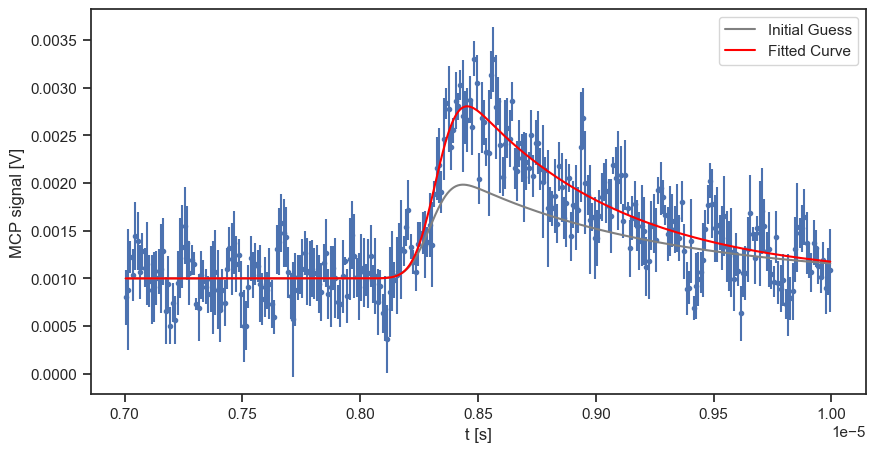

Ampl:	3.402549641223399e-08
mu:	1.1686735151496383e-05
sigma:	1.282817572144498e-07
lam:	1214589.343500017
Condition number of the covariance matrix: 4.312484e+27
Diagonal values of pcov:
Cov of Ampl:	1.600632082919619e-20
Cov of mu:	3.7691919318643765e-18
Cov of sigma:	5.386808061076317e-18
Cov of lam:	58109211.86869699
Chi-2: 1672.5112860239317
dof:	596
Reduced Chi^2:	2.8062269899730397
Goodness-of-Fit:	0.0
R-squared: 0.993498082345583


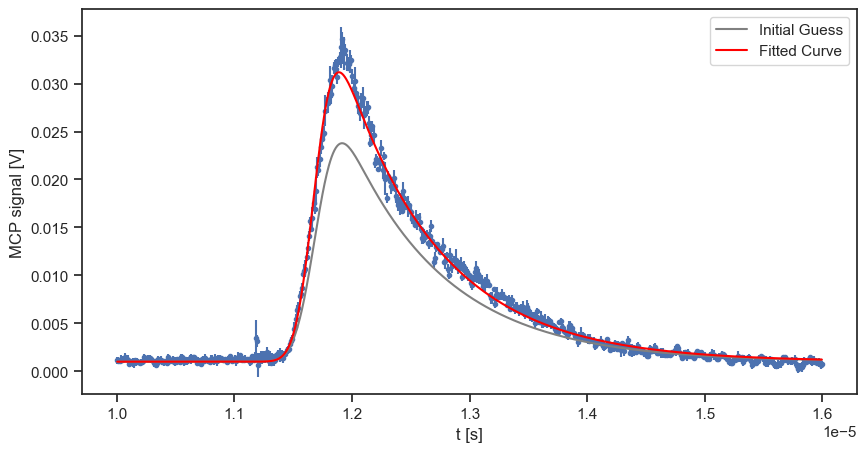

Ampl:	2.2002724795809527e-10
mu:	1.6899788478540477e-05
sigma:	3.0989140157751096e-07
lam:	112618851.58927596
Condition number of the covariance matrix: inf
Diagonal values of pcov:
Cov of Ampl:	2.335515877134278e-21
Cov of mu:	2.6763441996136487e-09
Cov of sigma:	2.210734794967752e-12
Cov of lam:	4.3150349552525335e+23
Chi-2: 213.38510592032728
dof:	196
Reduced Chi^2:	1.0886995200016698
Goodness-of-Fit:	0.18758728661880397
R-squared: 0.203823329532259


c:\ALPACA\analysis\volpe\volpe_library_2.py:604: RuntimeWarning: overflow encountered in exp
  #         factor3 = erfc((mu + lam * sigma**2 - x_i) / (np.sqrt(2) * sigma))
c:\ALPACA\analysis\volpe\volpe_library_2.py:606: RuntimeWarning: invalid value encountered in multiply
  #         # Check if any warnings were triggered


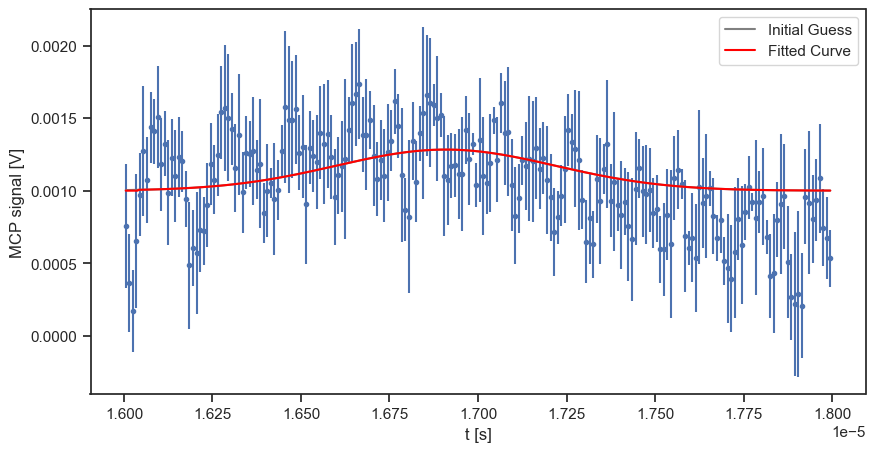

Ampl:	6.751990359940171e-10
mu:	1.881154552087245e-05
sigma:	3.795289010643139e-07
lam:	1962369.9597095377
Condition number of the covariance matrix: inf
Diagonal values of pcov:
Cov of Ampl:	1.0148550395314948e-20
Cov of mu:	2.5192925890826215e-14
Cov of sigma:	1.0661584600462294e-14
Cov of lam:	2263766559522.7837
Chi-2: 235.7682856063838
dof:	196
Reduced Chi^2:	1.2028994163591011
Goodness-of-Fit:	0.02742835757199924
R-squared: 0.3324447549600619


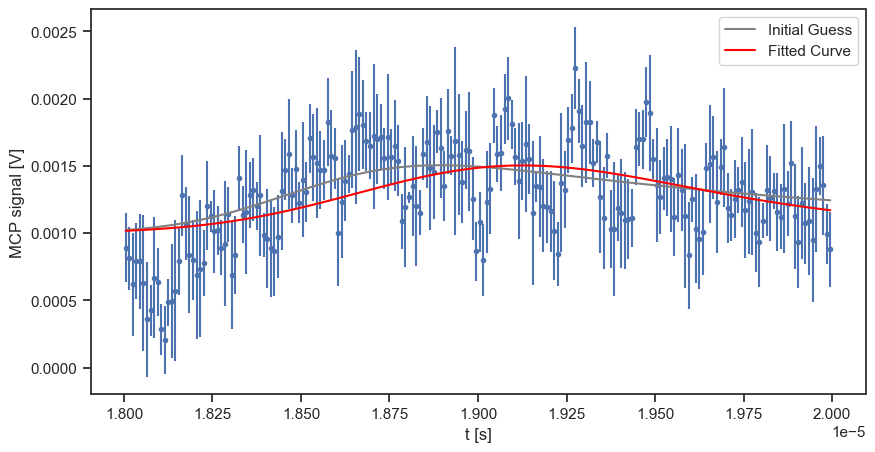

Ampl:	3.276823327411229e-09
mu:	2.1270740305997278e-05
sigma:	3.795070058779948e-07
lam:	953651.9066842268
Condition number of the covariance matrix: 1.061909e+30
Diagonal values of pcov:
Cov of Ampl:	5.496781665279522e-21
Cov of mu:	4.584240915120161e-16
Cov of sigma:	4.93283240572724e-16
Cov of lam:	3462236359.7052217
Chi-2: 478.53543333895675
dof:	396
Reduced Chi^2:	1.208422811462012
Goodness-of-Fit:	0.002768652772656255
R-squared: 0.7662596900621936


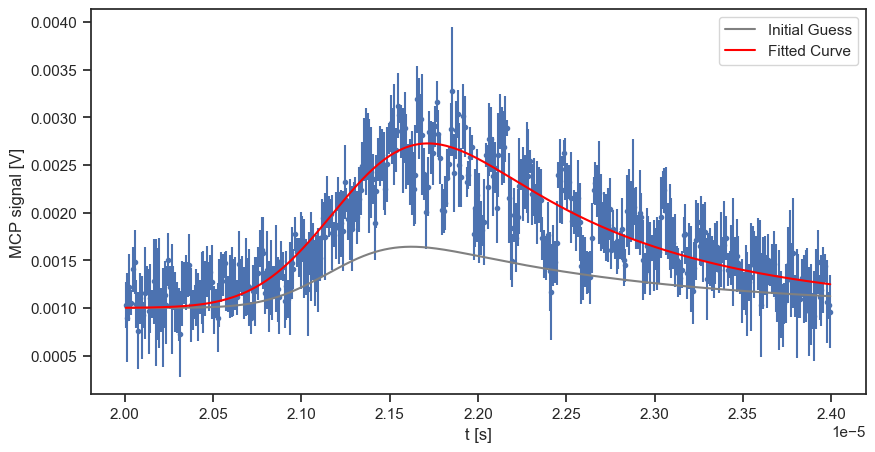

Ampl:	8.788750625270492e-09
mu:	2.58576205883944e-05
sigma:	2.9259453082229225e-07
lam:	575306.0874444537
Condition number of the covariance matrix: 3.753265e+28
Diagonal values of pcov:
Cov of Ampl:	1.12084052016628e-20
Cov of mu:	8.255069715520092e-17
Cov of sigma:	1.6093745649037528e-16
Cov of lam:	203731035.7645616
Chi-2: 987.9551589402683
dof:	596
Reduced Chi^2:	1.6576428841279671
Goodness-of-Fit:	0.0
R-squared: 0.9074334953005145


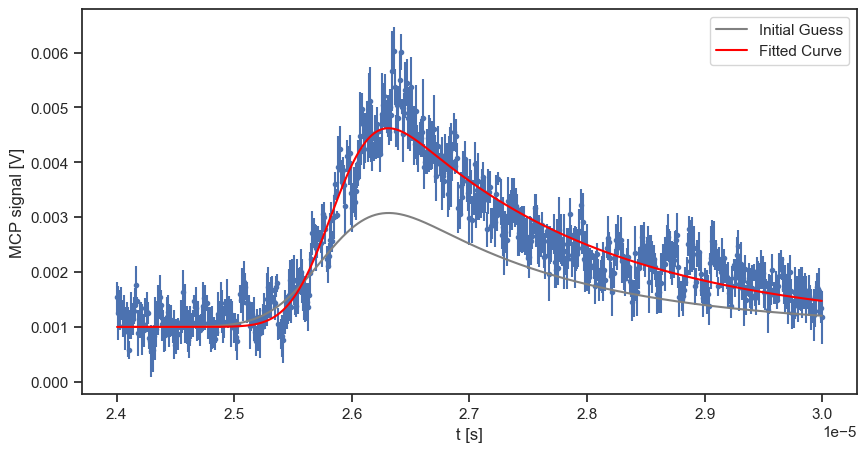

Ampl:	6.62135619031955e-09
mu:	3.6483137159157326e-05
sigma:	6.023032796346737e-07
lam:	366343.865574458
Condition number of the covariance matrix: 2.461335e+28
Diagonal values of pcov:
Cov of Ampl:	1.3452403389516059e-20
Cov of mu:	8.382082836616814e-16
Cov of sigma:	1.1720066195772004e-15
Cov of lam:	166843605.29200163
Chi-2: 1590.3911251157938
dof:	996
Reduced Chi^2:	1.596778238068066
Goodness-of-Fit:	0.0
R-squared: 0.6757749038631654


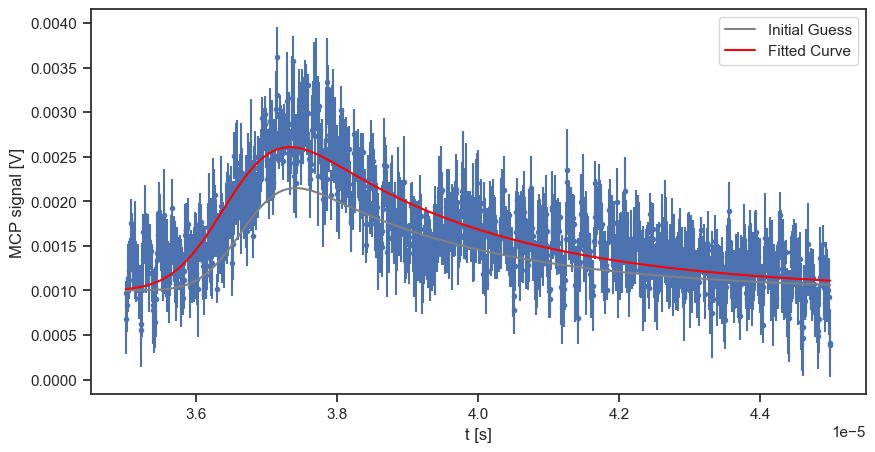

---------------------------------------------------------------------------
               Ampl           mu             sigma          lam            
peak_0         1.497e-09      8.324e-06      7.547e-08      1.546e+06      
peak_1         3.403e-08      1.169e-05      1.283e-07      1.215e+06      
peak_2         2.200e-10      1.690e-05      3.099e-07      1.126e+08      
peak_3         6.752e-10      1.881e-05      3.795e-07      1.962e+06      
peak_4         3.277e-09      2.127e-05      3.795e-07      9.537e+05      
peak_5         8.789e-09      2.586e-05      2.926e-07      5.753e+05      
peak_6         6.621e-09      3.648e-05      6.023e-07      3.663e+05      
------------------------------------------------------------


In [54]:
# Now let's do it serially! Peak by peak

multi_par_i = [[1e-9,   0.83e-5,    7.4e-8,     1.2e6],
            [2.65e-8,   1.17e-5,    1.4e-7,     1.2e6],
            [2.2e-10,   1.69e-5,    3.1e-7,     1.1e8],
            [9.8e-10,   1.85e-5,    2.7e-7,     7.6e5],
            [1.3e-9,    2.12e-5,    3.0e-7,     7.5e5],
            [4.9e-9,    2.58e-5,    3.8e-7,     6.7e5],
            [4.2e-9,    3.67e-5,    4.8e-7,     3.94e5]]

boundaries = [[0.7e-5,  1.0e-5],
            [1e-5,      1.6e-5],
            [1.6e-5,    1.8e-5],
            [1.8e-5,    2.0e-5],
            [2e-5,      2.4e-5],
            [2.4e-5,    3.0e-5],
            [3.5e-5,    4.5e-5]]

n_peaks = 7
multi_popt = np.zeros((n_peaks,n_params_fit_func))
multi_pcov = np.zeros((n_peaks,n_params_fit_func,n_params_fit_func))
# Peak by peak, serially
for i in range(0,n_peaks):
    df_temp = df2[(df2.index > boundaries[i][0]) & (df2.index < boundaries[i][1])]
    multi_popt[i], multi_pcov[i] = vl2.fit_n_plot_errors(df_temp, peak_fit_func, multi_par_i[i], ['Ampl', 'mu', 'sigma', 'lam'], verbose=verbose)
# Let's print the resulting fitting parameters
vl2.print_ToF_details(multi_popt.flatten(), row_headers=[f'peak_{i}' for i in range(n_peaks)])

Ampl:	2.5594773216410275e-10
mu:	1.679244597723675e-05
sigma:	2.611767888157416e-07
offset_3p:	-1.37496318982592e-06
Condition number of the covariance matrix: 1.182332e+10
Diagonal values of pcov:
Cov of Ampl:	1.925569920010622e-23
Cov of mu:	2.5507217928617308e-17
Cov of sigma:	2.8415857370198535e-17
Cov of offset_3p:	1.4265688153093325e-13
Chi-2: 197.6487855565526
dof:	8996
Reduced Chi^2:	0.02197074094670438
Goodness-of-Fit:	1.0
R-squared: 0.2763443293417275


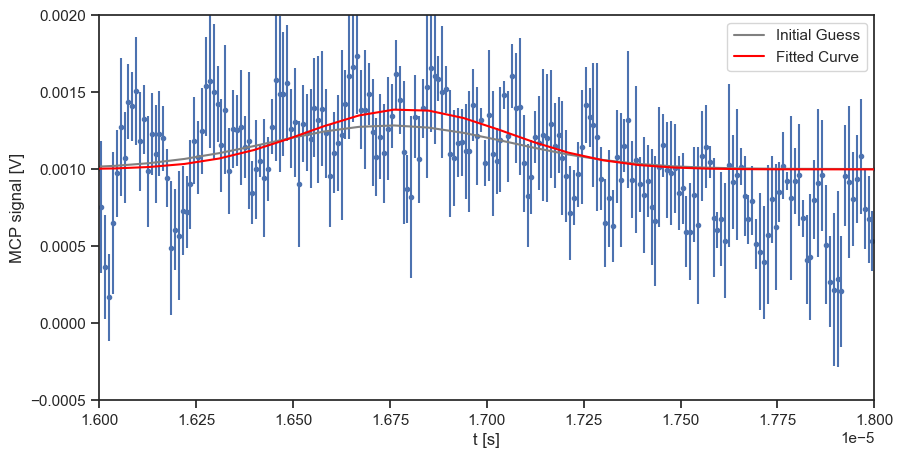

In [55]:
# Fixing third peak
df_3p = df2.copy()
# df_3p = df_3p[(df_3p.index > boundaries[2][0]) & (df_3p.index < boundaries[2][1])]
df_3p.loc[df_3p.index < 1.6e-5, 'values'] = plot_offset
df_3p.loc[df_3p.index > 1.8e-5, 'values'] = plot_offset
# Third peak fitting function
def third_peak_fit_func(x, ampl, mu, sigma, offset_3p):
    return vl2.Gauss(x, ampl, mu, sigma) + plot_offset + offset_3p
# Initial paramters
par_3p_i = [2.2e-10,   1.675e-5,    3.1e-7, 1e-6]
# plt.figure(figsize=(10, 5))
# plt.errorbar(df_3p.index, df_3p.iloc[:,0].values, yerr=df_3p.iloc[:,1].values, fmt='.')#, markersize=3)
# plt.plot(df_3p.index, third_peak_fit_func(df_3p.index, *par_3p_i), label='Initial Guess', color='grey')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.yscale('log')
# # plt.legend()
# plt.show()
popt_3p, pcov_3p = vl2.fit_n_plot_errors(df_3p, third_peak_fit_func, par_3p_i, ['Ampl', 'mu', 'sigma', 'offset_3p'], verbose=True, maxfev=100000, xlim=(1.6e-5,1.8e-5), ylim=(-0.0005, 0.002))

offset_3p:	1.3870999884224668e-06
Condition number of the covariance matrix: 1.000000e+00
Diagonal values of pcov:
Cov of offset_3p:	2.24578432915161e-13
Chi-2: 315.76162720146056
dof:	8999
Reduced Chi^2:	0.035088523969492226
Goodness-of-Fit:	1.0
R-squared: -2.4547131520336052e-05


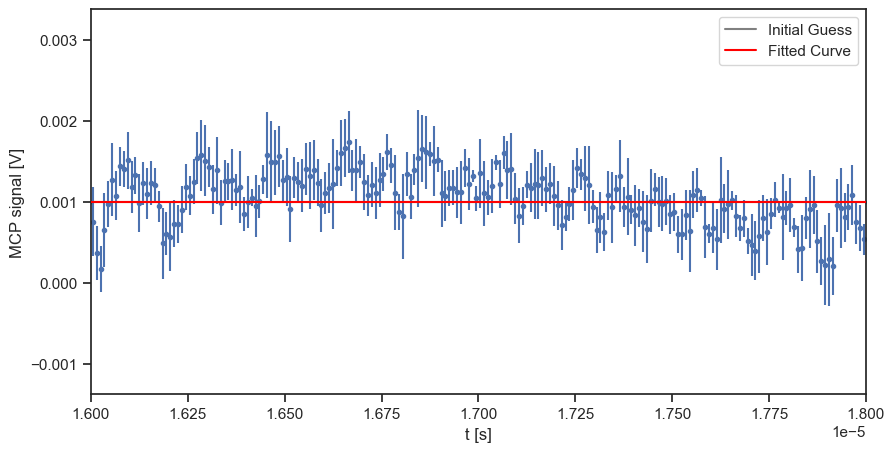

In [56]:
# And if we fit a constant?
df_3p_2 = df2.copy()
# df_3p = df_3p[(df_3p.index > boundaries[2][0]) & (df_3p.index < boundaries[2][1])]
df_3p_2.loc[df_3p_2.index < 1.6e-5, 'values'] = plot_offset
df_3p_2.loc[df_3p_2.index > 1.8e-5, 'values'] = plot_offset
# Third peak fitting function
def third_peak_fit_func(x, offset_3p):
    return np.full(len(x), plot_offset + offset_3p)
# Initial paramters
par_3p_2_i = [1e-6]
# plt.figure(figsize=(10, 5))
# plt.errorbar(df_3p.index, df_3p.iloc[:,0].values, yerr=df_3p.iloc[:,1].values, fmt='.')#, markersize=3)
# plt.plot(df_3p.index, third_peak_fit_func(df_3p.index, *par_3p_i), label='Initial Guess', color='grey')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.yscale('log')
# # plt.legend()
# plt.show()
popt_3p_2, pcov_3p_2 = vl2.fit_n_plot_errors(df_3p_2, third_peak_fit_func, par_3p_2_i, ['offset_3p'], verbose=True, maxfev=100000, xlim=(1.6e-5,1.8e-5))

[1.49691354e-09 8.32448348e-06 7.54664750e-08 1.54645873e+06
 3.40254964e-08 1.16867352e-05 1.28281757e-07 1.21458934e+06
 6.75199036e-10 1.88115455e-05 3.79528901e-07 1.96236996e+06
 3.27682333e-09 2.12707403e-05 3.79507006e-07 9.53651907e+05
 8.78875063e-09 2.58576206e-05 2.92594531e-07 5.75306087e+05
 6.62135619e-09 3.64831372e-05 6.02303280e-07 3.66343866e+05
 2.55947732e-10 1.67924460e-05 2.61176789e-07]


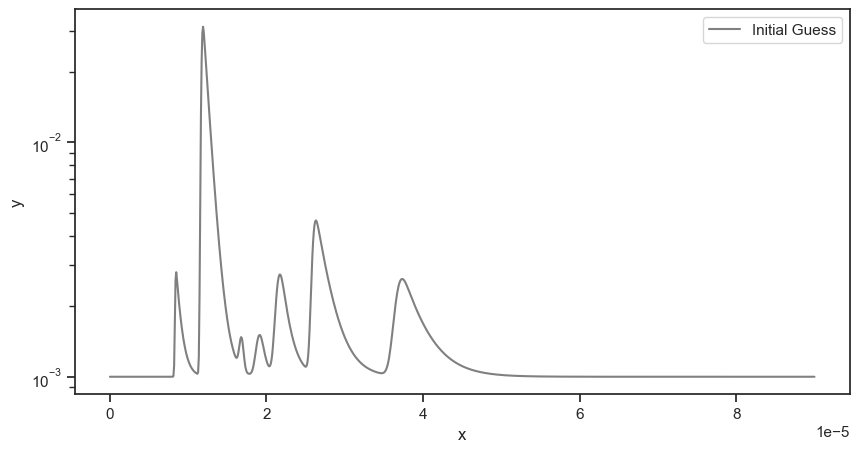

Ampl:	1.532839947624145e-09
mu:	8.321131567434377e-06
sigma:	7.268040607394182e-08
lam:	1459296.873891272
Condition number of the covariance matrix: 4.215641e+32
Diagonal values of pcov:
Cov of Ampl:	2.0240817529295613e-21
Cov of mu:	5.36529241541497e-17
Cov of sigma:	6.894845031299892e-17
Cov of lam:	5558478800.365427
Chi-2: 12526.743800656357
dof:	8973
Reduced Chi^2:	1.3960485679991483
Goodness-of-Fit:	0.0
R-squared: 0.9854034244965724


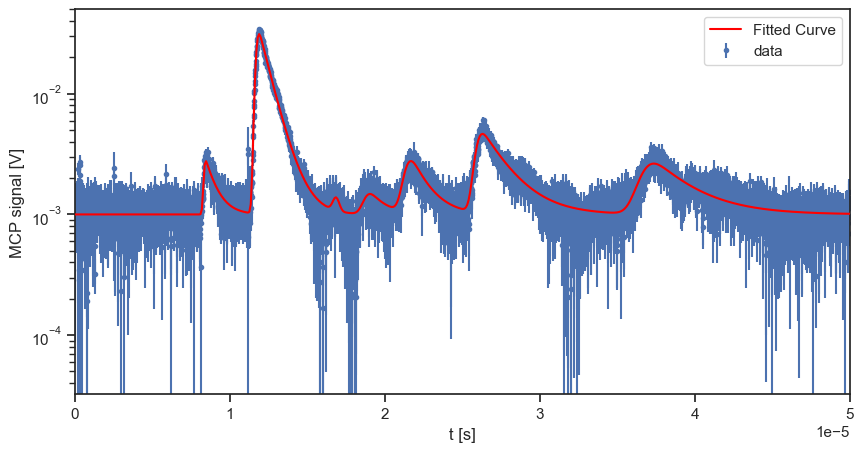

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[1.53283995e-09 8.32113157e-06 7.26804061e-08 1.45929687e+06
 3.39977715e-08 1.16870325e-05 1.28167062e-07 1.21601178e+06
 7.89495345e-10 1.86734217e-05 2.94539493e-07 9.95453869e+05
 3.16970937e-09 2.12822215e-05 3.18586209e-07 8.98818896e+05
 8.66372964e-09 2.58664204e-05 2.80508079e-07 5.77466769e+05
 6.34770005e-09 3.65265950e-05 6.06556145e-07 3.99541363e+05
 1.53556034e-10 1.68528343e-05 1.98811605e-07]


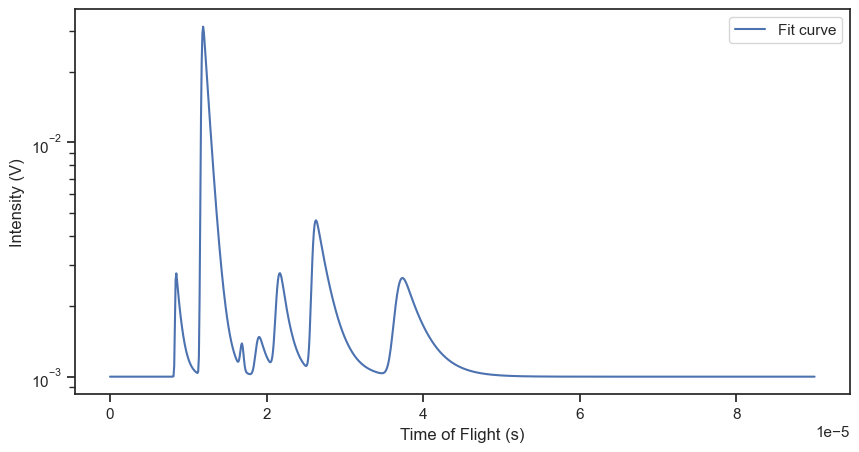

Starting parameters:
---------------------------------------------------------------------------
               Ampl           mu             sigma          lam            
peak_0         1.497e-09      8.324e-06      7.547e-08      1.546e+06      
peak_1         3.403e-08      1.169e-05      1.283e-07      1.215e+06      
peak_3         6.752e-10      1.881e-05      3.795e-07      1.962e+06      
peak_4         3.277e-09      2.127e-05      3.795e-07      9.537e+05      
peak_5         8.789e-09      2.586e-05      2.926e-07      5.753e+05      
peak_6         6.621e-09      3.648e-05      6.023e-07      3.663e+05      
peak_2         2.559e-10      1.679e-05      2.612e-07      0.000e+00      
------------------------------------------------------------
Fit parameters:
---------------------------------------------------------------------------
               Ampl           mu             sigma          lam            
peak_0         1.533e-09      8.321e-06      7.268e-08      1.459e

In [70]:
# Let's try to fit all the peaks together now
# Starting from the df where the oscillation has been subtracted
df3 = df2 
# Let's remove the third peak completely
multi_popt_wo3rdpeak = np.delete(multi_popt, 2, axis=0)
# Let's build the array of initial parameters, adding the third peak to the end
multifit_par_i = multi_popt_wo3rdpeak.flatten()
multifit_par_i = np.append(multifit_par_i, np.delete(popt_3p,3))
# vl2.print_ToF_details(multifit_par_i)
print(multifit_par_i)

n_peaks = 7 # Since I've removed it before
# Function fitting all peaks
def peak_fit_all(x, *args):
    # Start with the offset
    total = plot_offset 
    # Add the EMG peaks
    n_peaks_internal = 6
    for i in np.arange(n_peaks_internal): 
        total += vl2.EMG2(x, args[n_params_fit_func*i], args[n_params_fit_func*i+1], args[n_params_fit_func*i+2], args[n_params_fit_func*i+3])
        # print(f'params of {i}: {args[n_params_fit_func*i]}, {args[n_params_fit_func*i+1]}, {args[n_params_fit_func*i+2]}, {args[n_params_fit_func*i+3]}')
    # Manually add 3rd peak
    third_p_start_index = n_peaks_internal*n_params_fit_func
    total += vl2.Gauss(x, args[third_p_start_index],args[third_p_start_index+1],args[third_p_start_index+2])
    # print(f'Params of 3rd peak: {args[third_p_start_index]},{args[third_p_start_index+1]},{args[third_p_start_index+2]}')
    return total

# Generate the fitted curve
x_fit = np.linspace(min(df3.index.values), max(df3.index.values), 1000)
# Plot the data and the fitted curve
plt.figure(figsize=(10, 5))
# plt.errorbar(df3.index, df3.iloc[:,0].values, yerr=df3.iloc[:,1].values, fmt='.')#, markersize=3)
plt.plot(x_fit, peak_fit_all(x_fit, *multifit_par_i.flatten()), label='Initial Guess', color='grey')
plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.legend()
plt.show()

# Fit everything together
popt_tot, pcov_tot = vl2.fit_n_plot_errors_for_paper(df3, peak_fit_all, multifit_par_i, ['Ampl', 'mu', 'sigma', 'lam'], verbose=verbose, maxfev= 10000, yscale='log')
vl2._axes[-1].grid()
vl2._figures[-1].tight_layout()
vl2._figures[-1].savefig("fit-total.eps",dpi=600)
print(popt_tot)
row_headers=[f'peak_{i}' for i in np.concatenate((np.arange(0,2), np.arange(3,n_peaks)))] + ['peak_2']
if verbose:
    # Generate the fitted curve
    x_fit = np.linspace(min(df3.index.values), max(df3.index.values), 1000)
    # Plot the data and the fitted curve
    plt.figure(figsize=(10, 5))
    # plt.errorbar(df3.index, df3.iloc[:,0].values, yerr=df3.iloc[:,1].values, fmt='.')#, markersize=3)
    plt.plot(x_fit, peak_fit_all(x_fit, *popt_tot.flatten()), label='Fit curve')
    plt.xlabel('Time of Flight (s)')
    plt.ylabel('Intensity (V)')
    plt.yscale('log')
    plt.legend()
    plt.show()
    print('Starting parameters:')
    vl2.print_ToF_details(np.append(multifit_par_i,[0]), row_headers=row_headers)
print('Fit parameters:')
vl2.print_ToF_details(np.append(popt_tot,[0]), row_headers=row_headers)
print('Percentage variation:')
vl2.print_ToF_details(np.append((100*(multifit_par_i-popt_tot)/popt_tot).astype(int),[0]), row_headers=row_headers)

(1.1e-05, 1.4e-05)

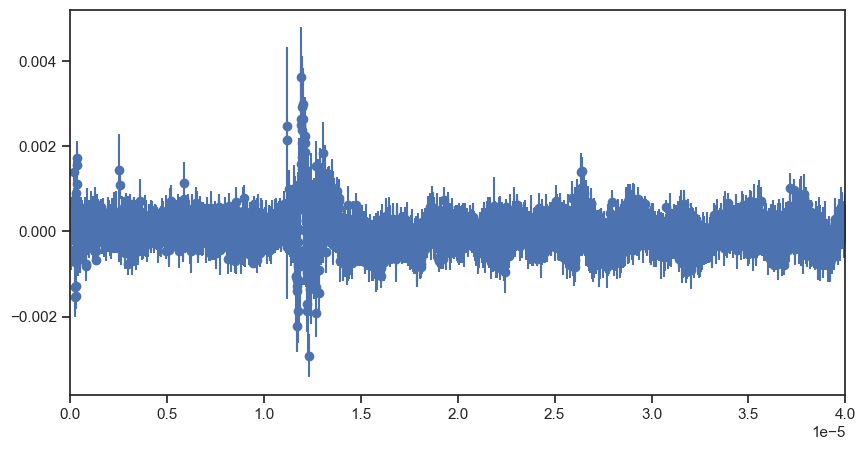

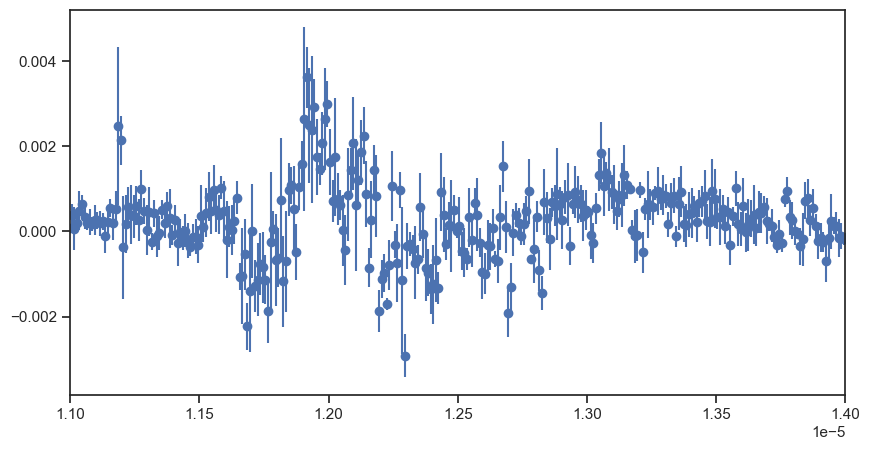

In [58]:
# Residuals estimation
df_residuals = df3.copy()
df_residuals['residuals'] = df_residuals['values'] - peak_fit_all(df_residuals.index, *multifit_par_i)
plt.figure(figsize=(10, 5))
# sns.scatterplot(df_residuals, x=df_residuals.index, y='residuals')
plt.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
plt.xlim(0,4e-5)
plt.figure(figsize=(10, 5))
plt.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
plt.xlim(1.1e-5, 1.4e-5)

In [59]:
import polars as pl

Q=1+ -> m/q=39.96238312204 -> tof=3.733414640772893e-05
Q=2+ -> m/q=19.98119156102 -> tof=2.6399228094716508e-05
Q=3+ -> m/q=13.320794374013333 -> tof=2.1554879478467196e-05
Q=4+ -> m/q=9.99059578051 -> tof=1.8667073203864465e-05
Q=5+ -> m/q=7.992476624408001 -> tof=1.669633784992229e-05
Q=6+ -> m/q=6.660397187006667 -> tof=1.5241601446882907e-05
Q=7+ -> m/q=5.708911874577143 -> tof=1.4110980972246598e-05
Q=8+ -> m/q=4.995297890255 -> tof=1.3199614047358254e-05
Q=9+ -> m/q=4.440264791337778 -> tof=1.2444715469242979e-05
Q=10+ -> m/q=3.9962383122040004 -> tof=1.1806093714661674e-05
Q=11+ -> m/q=3.6329439201854545 -> tof=1.1256668682057434e-05
Q=12+ -> m/q=3.3301985935033334 -> tof=1.0777439739233598e-05
Q=13+ -> m/q=3.074029470926154 -> tof=1.0354629169134333e-05
Q=14+ -> m/q=2.8544559372885714 -> tof=9.97797033466991e-06
Q=15+ -> m/q=2.6641588748026668 -> tof=9.639635152133572e-06
Q=16+ -> m/q=2.4976489451275 -> tof=9.333536601932232e-06
Q=17+ -> m/q=2.3507284189435294 -> tof=9.0548605

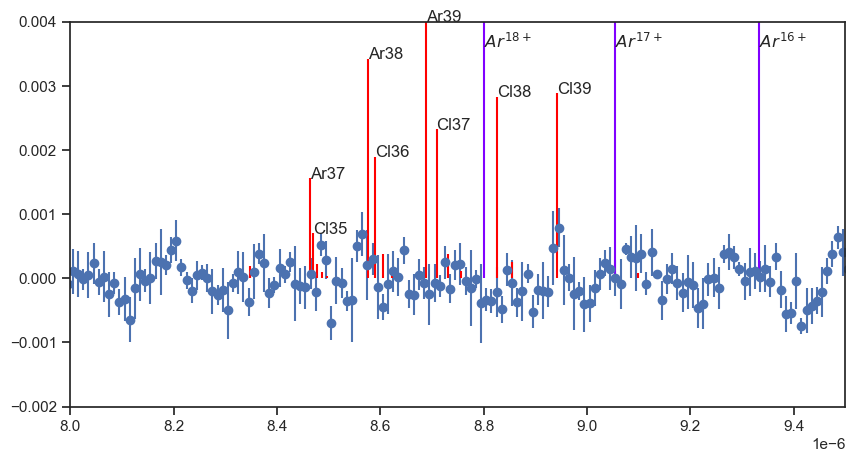

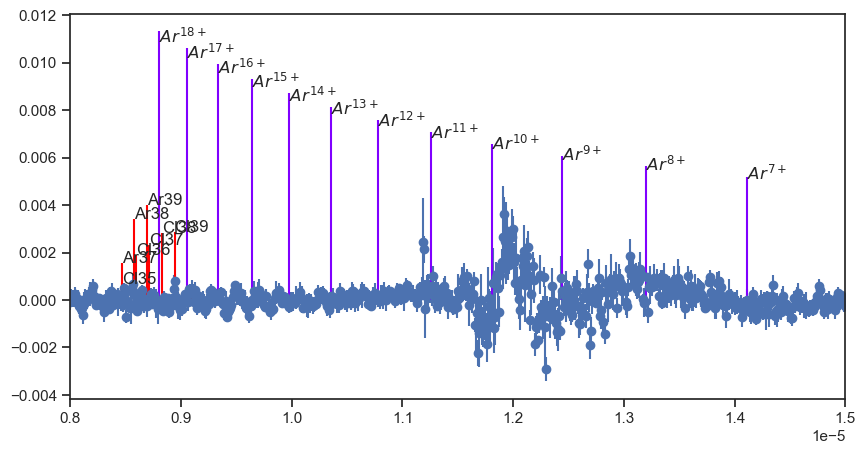

In [60]:
# load simulation data
df_sim = pl.read_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\trappable_Ar40_m-over-q.parquet").sort("tof_exp_s")
id_fragments = tof_fragments = pl.Series(df_sim.filter(pl.col("trappable_count").gt(0)).select("fragment")).to_list()
tof_fragments = pl.Series(df_sim.filter(pl.col("trappable_count").gt(0)).select("tof_exp_s")).to_list()
count_fragments = pl.Series(df_sim.filter(pl.col("trappable_count").gt(0)).select(pl.col("trappable_count").truediv(pl.col("trappable_count").max()))).to_list()
# print(id_fragments)
# print(tof_fragments)
# print(count_fragments)
# print(df_sim)

# load the mass of Ar40
m_Ar40 = (pl.scan_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\isotopes_info.parquet")
          .filter(pl.col("Z").eq(18),pl.col("N").eq(22))
          .select("atomic_mass")
          .collect()
          .item())


# print(m_Ar40)
q_Ar40 = np.array([q for q in range(1,19)])
mq_Ar40 = np.array([m_Ar40/q for q in q_Ar40])
tof_Ar40 = vl2.tof_from_mq(mq_Ar40)
# print(mq_Ar40)
# print(tof_Ar40)
for q in range(1,19):
    print(f"Q={q}+ -> m/q={m_Ar40/q} -> tof={vl2.tof_from_mq(m_Ar40/q)}")

# Residuals estimation
df_residuals = df3.copy()
df_residuals['residuals'] = df_residuals['values'] - peak_fit_all(df_residuals.index, *multifit_par_i)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
ax.set_xlim(0.8e-5, 0.95e-5)
ax.set_ylim(-0.002,0.004)

# ax.vlines(tof_fragments,0,np.array(count_fragments)*ax.get_ylim()[1],color=(1,0,0))
y_lim = ax.get_ylim()[1]
for i,fragment in enumerate(id_fragments):
    ax.vlines(tof_fragments[i],0,count_fragments[i]*y_lim,color=(1,0,0))
    if count_fragments[i] > 0.1:
        ax.text(tof_fragments[i],count_fragments[i]*y_lim, fragment)

for i,q in enumerate(q_Ar40):
    if tof_Ar40[i] > ax.get_xlim()[1]:
        continue
    ax.vlines(tof_Ar40[i],0,ax.get_ylim()[1],color=(0.5,0,1))
    ax.text(tof_Ar40[i],0.9*ax.get_ylim()[1], r"$Ar^{"+f"{q}"+r"+}$")

fig2 = plt.figure(figsize=(10, 5))
ax2 = fig2.add_subplot()
ax2.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
ax2.set_xlim(0.8e-5, 1.5e-5)
for i,fragment in enumerate(id_fragments):
    ax2.vlines(tof_fragments[i],0,count_fragments[i]*y_lim,color=(1,0,0))
    if count_fragments[i] > 0.1:
        ax2.text(tof_fragments[i],count_fragments[i]*y_lim, fragment)

for i,q in enumerate(q_Ar40):
    if tof_Ar40[i] > 1.5e-5:
        continue
    ax2.vlines(tof_Ar40[i],0,ax2.get_ylim()[1],color=(0.5,0,1))
    ax2.text(tof_Ar40[i],0.9*ax2.get_ylim()[1], r"$Ar^{"+f"{q}"+r"+}$")

# fig3 = plt.figure(figsize=(10, 5))
# ax3 = fig3.add_subplot()
# # ax3.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
# ax3.plot(x_fit, peak_fit_all(x_fit, *popt_tot.flatten()), label='Fit curve')
# # ax3.set_xlim(0.8e-5, 1.5e-5)
# for i,fragment in enumerate(id_fragments):
#     ax3.vlines(tof_fragments[i],0,count_fragments[i]*y_lim,color=(1,0,0))
#     if count_fragments[i] > 0.1:
#         ax3.text(tof_fragments[i],count_fragments[i]*y_lim, fragment)

# for i,q in enumerate(q_Ar40):
#     # if tof_Ar40[i] > 1.5e-5:
#     #     continue
#     ax3.vlines(tof_Ar40[i],0,ax2.get_ylim()[1],color=(0.5,0,1))
#     ax3.text(tof_Ar40[i],0.9*ax2.get_ylim()[1], r"$Ar^{"+f"{q}"+r"+}$")

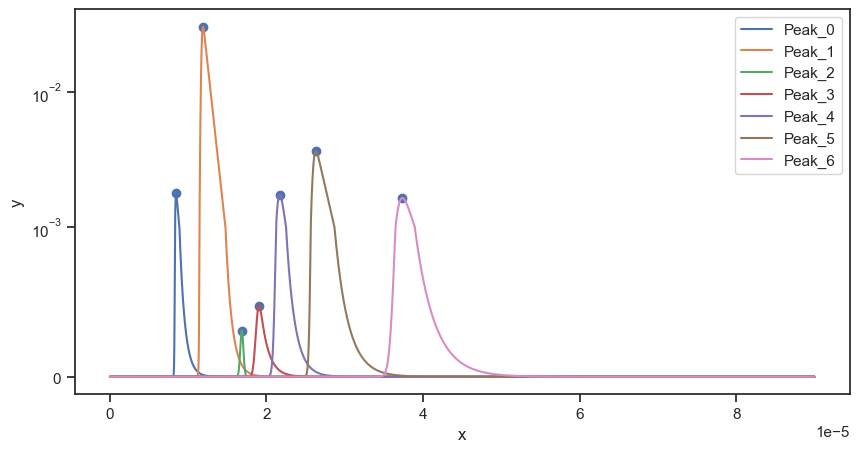

In [61]:
# For each peak, let's now extract raw observables (max height, integral and x_max) from the fitted curve
df4 = df3.copy()
# Create a column for each peak, with the fitted curve values
for i in range(0,2):
    # df4[f'peak_{i}'] = [vl2.EMG2(idx, *popt_tot[(i*n_params_fit_func):((i+1)*n_params_fit_func)]) for idx in df4.index]
    df4[f'peak_{i}'] = df4.index.to_series().apply(lambda idx: vl2.EMG2(idx, *popt_tot[i*n_params_fit_func:(i+1)*n_params_fit_func]))
# Manually change the 3rd peak
df4[f'peak_2'] = df4.index.to_series().apply(lambda idx: vl2.Gauss(idx, *popt_tot[-3:]))
# And the rest of the peaks
for i in range(2,n_peaks-1):
    df4[f'peak_{i+1}'] = df4.index.to_series().apply(lambda idx: vl2.EMG2(idx, *popt_tot[i*n_params_fit_func:(i+1)*n_params_fit_func]))
      
# Create the DataFrame
col_ids = [f'peak_{i}' for i in range(n_peaks)]
df_raw_observables = pd.DataFrame({
    'max_height': df4[col_ids].max().values,
    'integral'  : (bin_size * df4[col_ids].sum()).values,
    't_max'     : df4[col_ids].idxmax().values,
    'mu'        : popt_tot[1::4],
    # 'mean'      : popt_tot[1::4]+1/popt_tot[3::4]
    }, index=col_ids)
df_raw_observables['m/q']       = vl2.mq_from_tof(df_raw_observables['t_max'])
df_raw_observables['m/q_mu']    = vl2.mq_from_tof(df_raw_observables['mu'])
# df_raw_observables['m/q mean']  = vl2.mq_from_tof(df_raw_observables['mean'])
df_raw_observables['m/q std']   = vl2.mq_from_tof(df_raw_observables['t_max'], popt_tot[2::4])[1]
df_raw_observables['t_std']     = popt_tot[2::4]

# Plot the various curves, together with the points of the maximums
if verbose:
    # vl2.print_float_df(df_raw_observables)
    plt.figure(figsize=(10, 5))
    for i in range(n_peaks):
        plt.plot(df4.index, df4[f'peak_{i}'].values, label=f'Peak_{i}')
    plt.scatter(df_raw_observables['t_max'], df_raw_observables['max_height'])
    # plt.scatter(df_raw_observables['mu'], df_raw_observables['max_height'])
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.yscale('log')
    plt.yscale('symlog', linthresh=1e-3)
    # plt.ylim(1e-4, 2.5e-2)
    # # Add vertical red lines for each Ag state
    # for x_val in vl2.argon_m_q:
    #     plt.axvline(x=vl2.tof_from_mq(x_val), color='red', linestyle='--')
    plt.legend()
    plt.show()


       candidate        m/q     m/q_mu   m/q std  m/q cand  intensity
peak_0      He2+   2.044741   1.985197  0.044796    2.0013   0.120740
peak_1      He1+   4.056653   3.916043  0.103272    4.0026   5.355920
peak_2      Ag5+   8.145100   9.997392  0.305324    7.9900   0.004838
peak_3      Ag4+  10.399223  12.985924  0.375382    9.9870   0.031094
peak_4      Ag3+  13.494545  19.182782  0.393982   13.3160   0.166449
peak_5      Ag2+  19.838806  38.252278  0.953601   19.9740   0.682431
peak_6      Ag1+  40.007039   8.143007  0.689457   39.9480   1.000000


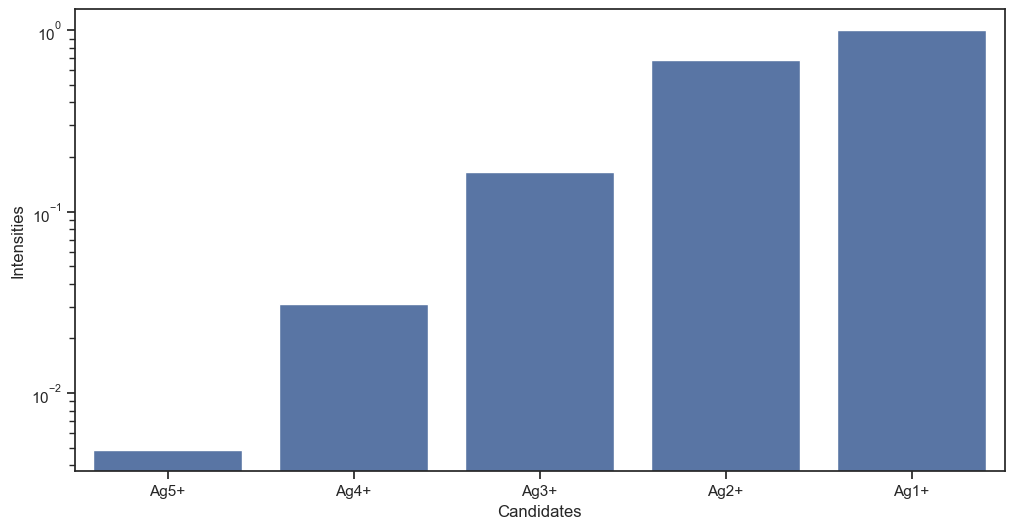

In [62]:
# Let's finalise it
df_obs = pd.DataFrame()
df_obs['m/q']       = df_raw_observables['m/q']
df_obs['m/q_mu']       = df_raw_observables['m/q_mu']
df_obs['m/q std']   = df_raw_observables['m/q std']
df_obs['m/q cand']  = [vl2.helium_mq(2),
                       vl2.helium_mq(1),
                       vl2.argon_mq(5),
                       vl2.argon_mq(4),
                       vl2.argon_mq(3),
                       vl2.argon_mq(2),
                       vl2.argon_mq(1)]
df_obs.insert(0, 'candidate', ['He2+',
                                'He1+',
                                'Ag5+',
                                'Ag4+',
                                'Ag3+',
                                'Ag2+',
                                'Ag1+'])
charges = [2,1,5,4,3,2,1]
df_obs['intensity'] = df_raw_observables['integral']/charges
df_obs['intensity'] = df_obs['intensity']/df_obs['intensity'].iloc[-1]

# print(df_obs.map(lambda x: f'{x:.2f}'))
print(df_obs)
# Bar plot with error bars
sns.barplot(x='candidate', y='intensity', data=df_obs.iloc[2:]) #, yerr=df['errors'])
# Add labels and title
plt.xlabel('Candidates')
plt.ylabel('Intensities')
plt.yscale('log')
# plt.title('Bar Chart with Error Bars')
plt.show()

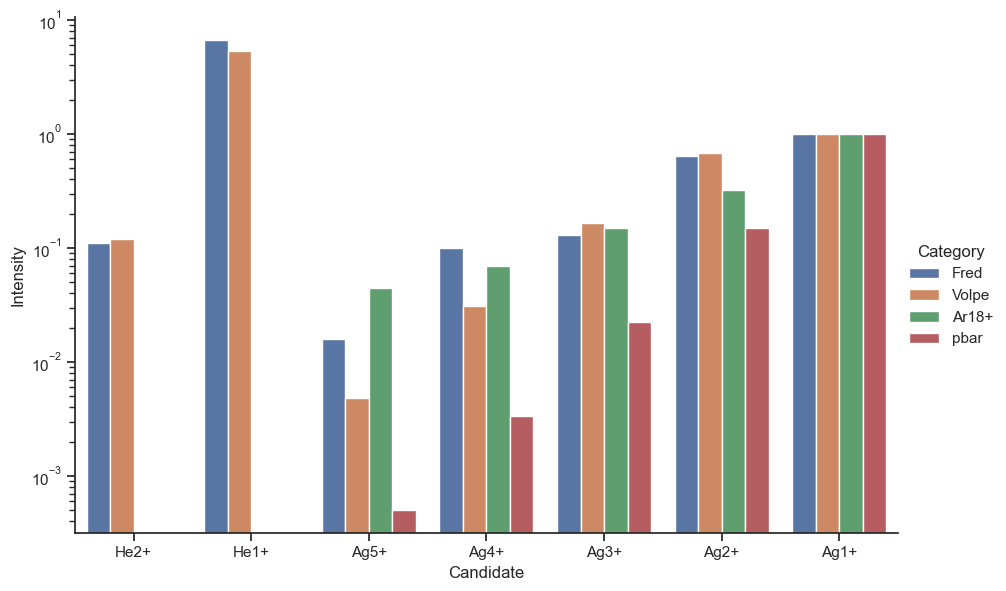

In [63]:
# Plot together Fredrik results
fred_intensities = [0.11,   6.61,   0.016,  0.1,    0.129,  0.637,  1]
ar18_intensities = [x/8.5 for x in [0,      0,      0.376,  0.589,  1.27,   2.76,   8.5]]
pbar_intensities = [x/20 for x in [0,      0,      0.0101, 0.0675,  0.45,   3,      20]]
indices_array = [['Fred']*7 + ['Volpe']*7 + ['Ar18+']*7 + ['pbar']*7,
                 df_obs['candidate'].values.tolist() * 4]

intensities_array = fred_intensities + df_obs['intensity'].values.tolist() + ar18_intensities + pbar_intensities
index = pd.MultiIndex.from_arrays(indices_array, names=('Category', 'Candidate'))
barchart_df = pd.DataFrame({'Intensity': intensities_array}, index=index)

# print(barchart_df)

sns.catplot(data=barchart_df, x='Candidate', y='Intensity', hue='Category', kind='bar', height=6, aspect=1.5)
plt.yscale('log')